In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.api import VAR

In [8]:
class StockTicker():
    columns_to_drop = ['volume','dividends', 'stock_splits'] # 'date', 
    
    def __init__(self, ticker, period="max"):
        self.df = pd.DataFrame().ta.ticker(ticker, period=period)
        self.df.ta.adjusted = "adj_close"
        self.clean_columns()
        self.add_moving_average()
        self.add_target()
        self.df.dropna(inplace=True)
        #self.df['weekday'] = self.df['date'].dt.day_of_week # numeric encoded day of week
        
    def clean_columns(self):
        self.df.reset_index(inplace=True)
        self.df.columns = self.df.columns.str.lower().str.replace(' ', '_')
        self.df.drop(self.columns_to_drop, axis=1, inplace=True)
        
    def add_moving_average(self):
        self.df['rsi']  = ta.rsi(self.df.close, length=15)
        self.df['emaf'] = ta.ema(self.df.close, length=20) #fast moving avg
        self.df['emam'] = ta.ema(self.df.close, length=100) #medium moving avg
        self.df['emas'] = ta.ema(self.df.close, length=150) #slow moving avg

    def add_target(self):
        self.df['target']            = self.df.close - self.df.open
        self.df['target']            = self.df.target.shift(-1)
        self.df['target_class']      = [1 if self.df.target[i]>0 else 0 for i in range(len(self.df))]
        self.df['target_next_close'] = self.df.close.shift(-1)

    @property
    def features(self):
        return self.df[['open', 'high', 'low', 'close', 'rsi', 'emaf', 'emas', 'emam']]
    
    @property
    def targets(self):
        return self.df[['target', 'target_class', 'target_next_close']]
    
    @property
    def dataframe(self):
        return self.df


In [9]:
ticker = StockTicker('adbe')

In [10]:
ticker.dataframe

,date,open,high,low,close,rsi,emaf,emam,emas,target,target_class,target_next_close,weekday
149,1987-03-17 00:00:00-05:00,1.026960,1.041631,0.924264,0.982948,80.631485,0.802095,0.522994,0.398400,-0.040345,0,0.942603,1
150,1987-03-18 00:00:00-05:00,0.982948,0.997619,0.938935,0.942603,73.040201,0.815477,0.531303,0.405608,0.007335,1,0.953606,2
151,1987-03-19 00:00:00-05:00,0.946271,0.968277,0.946271,0.953606,73.762060,0.828632,0.539666,0.412866,-0.036677,0,0.916929,3
152,1987-03-20 00:00:00-05:00,0.953606,0.968277,0.909594,0.916929,67.324447,0.837041,0.547136,0.419542,-0.080690,0,0.836239,4
153,1987-03-23 00:00:00-05:00,0.916930,0.953606,0.828904,0.836239,55.837431,0.836965,0.552861,0.425061,0.029342,1,0.865581,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9408,2023-12-12 00:00:00-05:00,625.859985,633.890015,623.000000,633.659973,68.179335,606.222889,548.757092,521.895492,-6.149963,0,624.260010,1
9409,2023-12-13 00:00:00-05:00,630.409973,632.450012,618.030029,624.260010,62.241614,607.940710,550.252200,523.251314,-8.359985,0,584.640015,2
9410,2023-12-14 00:00:00-05:00,593.000000,593.159973,578.299988,584.640015,44.672243,605.721597,550.933147,524.064409,4.080017,1,584.679993,3
9411,2023-12-15 00:00:00-05:00,580.599976,591.659973,578.200012,584.679993,44.689122,603.717634,551.601401,524.867265,7.609985,1,599.130005,4


In [52]:
# (1) Create the Strategy
MyStrategy = ta.Strategy(
    name="DCSMA10",
    ta=[
        {"kind": "ohlc4"},
        {"kind": "sma", "length": 10},
        {"kind": "donchian", "lower_length": 10, "upper_length": 15},
        {"kind": "ema", "close": "OHLC4", "length": 10, "suffix": "OHLC4"},
    ]
)

# (2) Run the Strategy
ticker.dataframe.ta.strategy(MyStrategy)

In [46]:
#from sklearn.model_selection import TimeSeriesSplit
#tscv = TimeSeriesSplit(n_splits=3)

#print(tscv.split(ticker.dataframe))

#for train_index, test_index in tscv.split(ticker.dataframe):
#    print(train_index)
#    break;
#    X_train, X_test = ticker.features[train_index], ticker.features[test_index]
#    y_train, y_test = ticker.targets[train_index],  ticker.targets[test_index]

    # Fit your model on the training data
#    model = LinearRegression()
#    model.fit(X_train, y_train)

    # Evaluate your model on the test data
#    accuracy = model.score(X_test, y_test)
#    print("Model Accuracy:", accuracy)

In [11]:
train_size = int(len(ticker.dataframe) * 0.8)
train_features, test_features = ticker.features[:train_size], ticker.features[train_size:]
train_targets,  test_targets  = ticker.targets[:train_size],  ticker.targets[train_size:]


# Create a preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',  MinMaxScaler(feature_range=(0,1)))
])

# Apply the preprocessing pipeline to numeric features
preprocessor = ColumnTransformer(transformers=[
    ('num', preprocessing_pipeline, ticker.features.columns)
])

# Fit and transform the training data
train_features_preprocessed = preprocessor.fit_transform(train_features)

# Transform the test data using the learned parameters from the training data
test_features_preprocessed  = preprocessor.transform(test_features)

In [12]:
def reshape_for_lstm(data, time_steps):
    return data.reshape((data.shape[0], time_steps, data.shape[1]))

time_steps = 1  # You can experiment with different time steps
train_features_lstm = reshape_for_lstm(train_features_preprocessed, time_steps)
test_features_lstm  = reshape_for_lstm(test_features_preprocessed,  time_steps)


In [13]:
model = Sequential()
time_steps = 1
model.add(LSTM(units=50, activation='relu', input_shape=(time_steps, ticker.features.shape[1])))
model.add(Dense(units=3))  # Assuming you have 3 output columns

model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust the loss function based on your problem

2023-12-19 18:13:53.329089: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-19 18:13:53.329254: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-19 18:13:53.329266: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-19 18:13:53.330002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-19 18:13:53.330746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
epochs = 50
batch_size = 32

model.fit(train_features_lstm, train_targets, epochs=epochs, batch_size=batch_size)

Epoch 1/50


2023-12-19 18:13:58.294414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


232/232 [==============================] - 3s 12ms/step - loss: 308.4913
Epoch 2/50
232/232 [==============================] - 2s 10ms/step - loss: 120.5901
Epoch 3/50
232/232 [==============================] - 2s 10ms/step - loss: 15.2256
Epoch 4/50
232/232 [==============================] - 2s 10ms/step - loss: 1.6029
Epoch 5/50
232/232 [==============================] - 2s 10ms/step - loss: 0.6495
Epoch 6/50
232/232 [==============================] - 2s 10ms/step - loss: 0.5257
Epoch 7/50
232/232 [==============================] - 2s 10ms/step - loss: 0.4874
Epoch 8/50
232/232 [==============================] - 2s 10ms/step - loss: 0.4710
Epoch 9/50
232/232 [==============================] - 2s 10ms/step - loss: 0.4592
Epoch 10/50
232/232 [==============================] - 2s 10ms/step - loss: 0.4529
Epoch 11/50
232/232 [==============================] - 2s 10ms/step - loss: 0.4486
Epoch 12/50
232/232 [==============================] - 2s 10ms/step - loss: 0.4433
Epoch 13/50
232/232

In [15]:
test_loss = model.evaluate(test_features_lstm, test_targets)
print(f'Test Loss: {test_loss}')


58/58 [==============================] - 0s 5ms/step - loss: 650.1931
Test Loss: 650.1930541992188


58/58 [==============================] - 0s 4ms/step


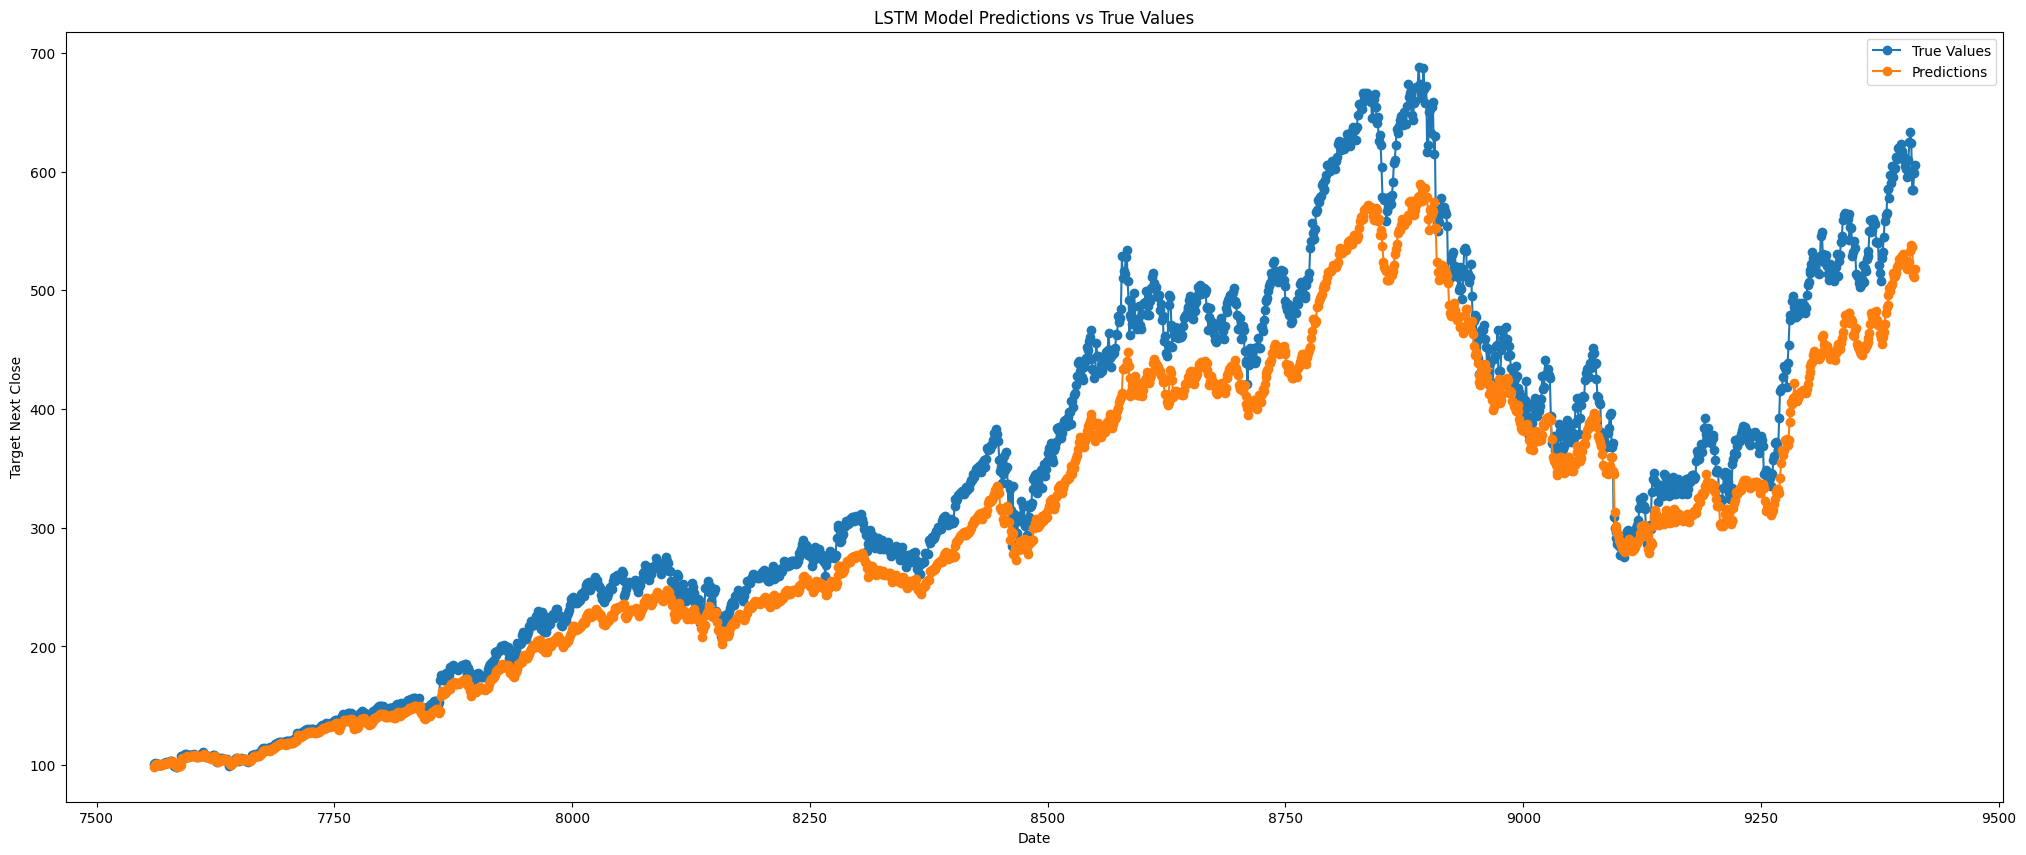

In [16]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained LSTM model
predictions = model.predict(test_features_lstm)

# Plotting
plt.figure(figsize=(25, 10))
plt.plot(test_targets.index, test_targets.target_next_close, label='True Values', marker='o')
plt.plot(test_targets.index, predictions[:, 2], label='Predictions', marker='o')  # Assuming 'target_next_close' is the third column
plt.title('LSTM Model Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Target Next Close')
plt.legend()
plt.show()

Epoch 1/50
232/232 [==============================] - 3s 12ms/step - loss: 0.3712 - val_loss: 672.2236
Epoch 2/50
232/232 [==============================] - 3s 11ms/step - loss: 0.3712 - val_loss: 665.3534
Epoch 3/50
232/232 [==============================] - 3s 11ms/step - loss: 0.3707 - val_loss: 657.5505
Epoch 4/50
232/232 [==============================] - 3s 11ms/step - loss: 0.3721 - val_loss: 659.4037
Epoch 5/50
232/232 [==============================] - 3s 11ms/step - loss: 0.3697 - val_loss: 667.8153
Epoch 6/50
232/232 [==============================] - 3s 11ms/step - loss: 0.3696 - val_loss: 647.0141
Epoch 7/50
232/232 [==============================] - 3s 11ms/step - loss: 0.3669 - val_loss: 633.2018
Epoch 8/50
232/232 [==============================] - 3s 11ms/step - loss: 0.3669 - val_loss: 660.2167
Epoch 9/50
232/232 [==============================] - 3s 11ms/step - loss: 0.3670 - val_loss: 665.4175
Epoch 10/50
232/232 [==============================] - 3s 11ms/step - los

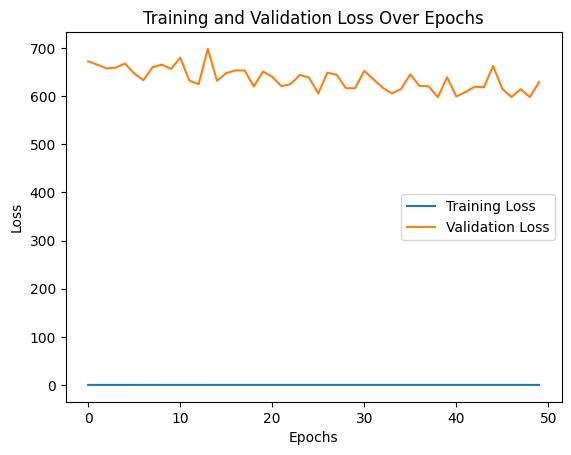

In [17]:
history = model.fit(train_features_lstm, train_targets, epochs=epochs, batch_size=batch_size, validation_data=(test_features_lstm, test_targets))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [120]:

serializer = ModelSerializer('../models/stock_prediction_model.sav')
model = serializer.load()

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = model.predict(test_features_lstm)
mae = mean_absolute_error(test_targets['target_next_close'], predictions[:, 2])  # Assuming 'target_next_close' is the third column
mse = mean_squared_error(test_targets['target_next_close'], predictions[:, 2])
rmse = np.sqrt(mse)


print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

58/58 [==============================] - 0s 3ms/step
MAE: 34.18
MSE: 1843.84
RMSE: 42.94


In [19]:
from sklearn.metrics import accuracy_score

# Assuming 'target_class' is the classification target column
predictions_class = (predictions[:, 1] > 0.5).astype(int)
accuracy = accuracy_score(test_targets['target_class'], predictions_class)

print(f'Directional Accuracy: {accuracy:.2%}')

Directional Accuracy: 52.78%


# Saving the model

In [123]:
import pickle
class ModelSerializer:
    """
    Save and Load Models into a file specified in the constructor.
    
    ModelSerializer('models/best_model.sav').save(model)
    ModelSerializer('models/best_model.sav').load()
    """

    def __init__(self, filename='models/model.sav'):
        self.filename = filename
        
    def save(self, model):
        return pickle.dump(model, self.file('wb'))
    
    def load(self):
        return pickle.load(self.file())
    
    def file(self, mode='rb'):
        return open(self.filename, mode)

    

serializer = ModelSerializer('../models/stock_prediction_model.sav')
serializer.save(model)


model = serializer.load()


In [45]:
#model.predict(ticker.features)

In [ ]:
model.predicts()